## Goals

This is an example of the current capacities of echopype processing for the EK80 echosounder. Inspired by
https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/ms_PacificHake_EK60_cruisetracks.ipynb

## Description


In [1]:
import fsspec
import numpy as np
import geopandas as gpd
import xarray as xr
import echopype as ep
import echopype.visualize as epviz
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Data import

File is https://noaa-wcsd-pds.s3.amazonaws.com/data/raw/Sally_Ride/SR1611/EK80/D20161109-T163350.raw

In [2]:
raw_file_address = "noaa-wcsd-pds.s3.amazonaws.com/data/raw/Sally_Ride/SR1611/EK80/D20161109-T163350.raw"

#### Metadata creation

In [3]:
def populate_metadata(ed, raw_fname):
    """
    Manually populate into the "ed" EchoData object 
    additional metadata about the dataset and the platform
    """
    
    # -- SONAR-netCDF4 Top-level Group attributes
    survey_name = (
        "Sally Ride survey"
    )
    ed['Top-level'].attrs['title'] = f"{survey_name}, file {raw_fname}"
    ed['Top-level'].attrs['summary'] = (
        f"EK80 raw file {raw_fname} from the {survey_name}, converted to a SONAR-netCDF4 file using echopype."
    )

    # -- SONAR-netCDF4 Platform Group attributes
    # Per SONAR-netCDF4, for platform_type see https://vocab.ices.dk/?ref=311
    ed['Platform'].attrs['platform_type'] = "Research vessel"
    ed['Platform'].attrs['platform_name'] = "Sally Ride"  # A NOAA ship

In [4]:
base_dpath = Path('./exports/basic_echopype_processing_ek80')
base_dpath.mkdir(exist_ok=True, parents=True)

converted_dpath = Path(base_dpath / 'convertedzarr')
converted_dpath.mkdir(exist_ok=True)
calibrated_dpath = (base_dpath / 'calibratednc')
calibrated_dpath.mkdir(exist_ok=True)

## Single file processing

In [5]:
rf = Path(raw_file_address)
rf


PosixPath('noaa-wcsd-pds.s3.amazonaws.com/data/raw/Sally_Ride/SR1611/EK80/D20161109-T163350.raw')

In [6]:

ed = ep.open_raw(
            #f"s3://{rf}",
            f"https://{rf}",
            sonar_model='EK80',
            #storage_options={'anon': True}
        )

# Manually populate additional metadata about the dataset and the platform
populate_metadata(ed, rf.name)

In [7]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains complex backscatter data and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

In [8]:
ed.group_map

{'top': {'name': 'Top-level',
  'description': 'contains metadata about the SONAR-netCDF4 file format.',
  'ep_group': None},
 'environment': {'name': 'Environment',
  'description': 'contains information relevant to acoustic propagation through water.',
  'ep_group': 'Environment'},
 'platform': {'name': 'Platform',
  'description': 'contains information about the platform on which the sonar is installed.',
  'ep_group': 'Platform'},
 'nmea': {'name': 'NMEA',
  'description': 'contains information specific to the NMEA protocol.',
  'ep_group': 'Platform/NMEA'},
 'provenance': {'name': 'Provenance',
  'description': 'contains metadata about how the SONAR-netCDF4 version of the data were obtained.',
  'ep_group': 'Provenance'},
 'sonar': {'name': 'Sonar',
  'description': 'contains sonar system metadata and sonar beam groups.',
  'ep_group': 'Sonar'},
 'beam': {'name': 'Beam_group1',
  'description': 'contains backscatter data (either complex samples or uncalibrated power samples) and o

#### Check that we can access sonar data

In [9]:
sonar = ed["Sonar/Beam_group1"]
sonar

<xarray.Dataset>
Dimensions:                        (channel: 5, ping_time: 13, beam: 4,
                                    range_sample: 123897)
Coordinates:
  * channel                        (channel) <U22 'WBT 545604-15 ES38B' ... '...
  * ping_time                      (ping_time) datetime64[ns] 2016-11-09T16:3...
  * range_sample                   (range_sample) int64 0 1 2 ... 123895 123896
  * beam                           (beam) <U21 '1' '2' '3' '4'
Data variables: (12/21)
    frequency_nominal              (channel) float64 3.8e+04 1.8e+04 ... 7e+04
    beam_type                      (channel, ping_time) int64 1 1 1 1 ... 1 1 1
    beamwidth_twoway_alongship     (channel, ping_time, beam) float64 7.1 ......
    beamwidth_twoway_athwartship   (channel, ping_time, beam) float64 7.1 ......
    beam_direction_x               (channel, ping_time, beam) float64 nan ......
    beam_direction_y               (channel, ping_time, beam) float64 nan ......
    ...                             ...
    frequency_start                (channel, ping_time, beam) float64 3.8e+04...
    frequency_end                  (channel, ping_time, beam) float64 3.8e+04...
    sample_interval                (channel, ping_time) float64 8e-06 ... 4.2...
    transmit_power                 (channel, ping_time) float64 2e+03 ... 1e+03
    transmit_duration_nominal      (channel, ping_time) float32 0.000256 ... ...
    slope                          (channel, ping_time) float64 0.5 0.5 ... 0.5
Attributes:
    beam_mode:              vertical
    conversion_equation_t:  type_3

Both backscatter_r and backscatter_i are populated, so we have complex data stored in beam 1. Let's check if there is any power/angle data stored in beam 2

In [10]:
sonar2 = ed["Sonar/Beam_group2"]
sonar2

All good, we're only handling complex data.

In [11]:
frequencies = sonar['channel']
frequencies

<xarray.DataArray 'channel' (channel: 5)>
array(['WBT 545604-15 ES38B', 'WBT 545605-15 ES18-11',
       'WBT 545608-15 ES120-7C', 'WBT 545610-15 ES200-7C',
       'WBT 562921-15 ES70-7C'], dtype='<U22')
Coordinates:
  * channel  (channel) <U22 'WBT 545604-15 ES38B' ... 'WBT 562921-15 ES70-7C'
Attributes:
    long_name:  Vendor channel ID

We appear to have a five-frequency instrument - 18, 38, 70, 120, 200 kHz

#### SV computation and denoising

In [12]:
# Compute base SV
ds_Sv = ep.calibrate.compute_Sv(
    ed,
    waveform_mode="BB", #complex mode, otherwise it would be CW
    encode_mode="complex" #complex mode, otherwise it would be power
)
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 5, ping_time: 13,
                                    range_sample: 123897, filenames: 1, time3: 1)
Coordinates:
  * channel                        (channel) <U22 'WBT 545604-15 ES38B' ... '...
  * ping_time                      (ping_time) datetime64[ns] 2016-11-09T16:3...
  * range_sample                   (range_sample) int64 0 1 2 ... 123895 123896
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2016-11-09T16:33:50...
Data variables: (12/24)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.8e+04 ... 7e+04
    sound_speed                    float64 1.514e+03
    sound_absorption               (channel, ping_time) float64 0.007929 ... ...
    temperature                    float64 10.0
    ...                             ...
    beamwidth_athwartship          (channel, ping_time) float64 7.1 7.1 ... 7.0
    impedance_transducer           (channel, ping_time) int64 75 75 75 ... 75 75
    impedance_transceiver          int64 1000
    receiver_sampling_frequency    (channel) int64 1500000 1500000 ... 1500000
    source_filenames               (filenames) <U92 'https://noaa-wcsd-pds.s3...
    water_level                    (time3) float64 nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2023-06-30T13:28:19Z
    processing_function:          calibrate.compute_Sv

In [13]:
#Remove background noise
ds_Sv_clean = ep.preprocess.remove_noise(    # obtain a denoised Sv dataset
   ds_Sv,             # calibrated Sv dataset
   range_sample_num=30,  # number of samples along the range_sample dimension for estimating noise
   ping_num=5,        # number of pings for estimating noise
)

ds_Sv_clean

<xarray.Dataset>
Dimensions:                        (channel: 5, ping_time: 13,
                                    range_sample: 123897, filenames: 1, time3: 1)
Coordinates:
  * channel                        (channel) <U22 'WBT 545604-15 ES38B' ... '...
  * ping_time                      (ping_time) datetime64[ns] 2016-11-09T16:3...
  * range_sample                   (range_sample) int64 0 1 2 ... 123895 123896
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2016-11-09T16:33:50...
Data variables: (12/26)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.8e+04 ... 7e+04
    sound_speed                    float64 1.514e+03
    sound_absorption               (channel, ping_time) float64 0.007929 ... ...
    temperature                    float64 10.0
    ...                             ...
    impedance_transceiver          int64 1000
    receiver_sampling_frequency    (channel) int64 1500000 1500000 ... 1500000
    source_filenames               (filenames) <U92 'https://noaa-wcsd-pds.s3...
    water_level                    (time3) float64 nan
    Sv_noise                       (channel, ping_time, range_sample) float64 ...
    Sv_corrected                   (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2023-06-30T13:28:20Z
    processing_function:          clean.remove_noise

#### Visualising our initial data

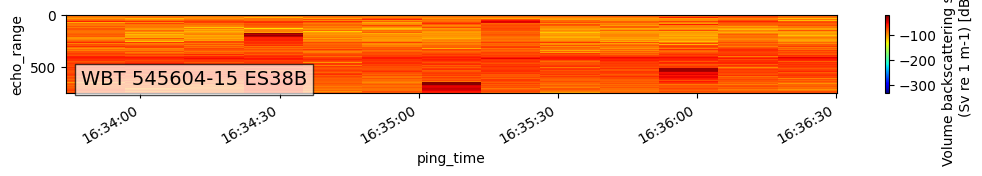

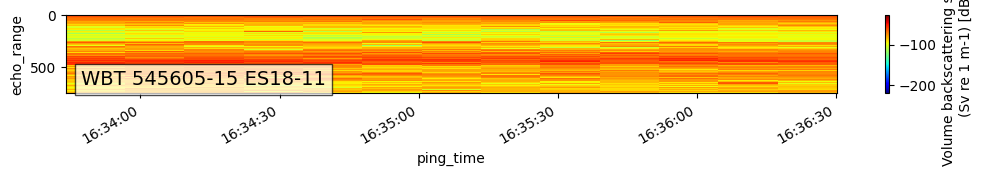

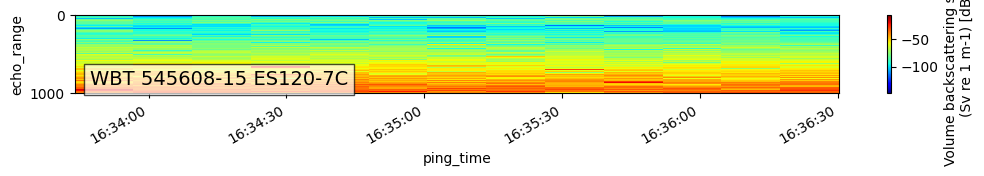

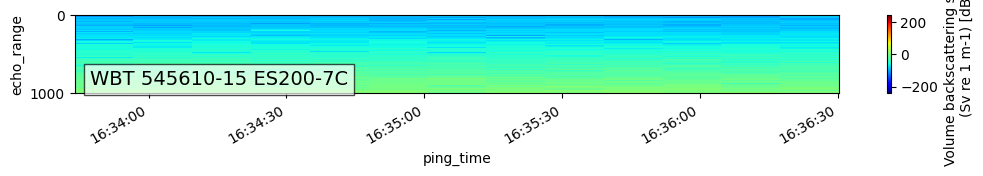

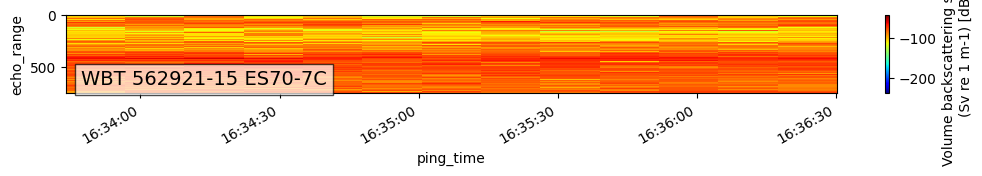

In [14]:
#Let's visualise this
epviz.create_echogram(ds_Sv_clean)

#### Plankton detection

Let's try searching for krill. This is done by creating a mask that only keeps points with a Sv difference between 2 and 16 dB between the 120 and the 38 kHz channels


In [15]:


low_mask = ep.mask.frequency_differencing(source_Sv=ds_Sv_clean, storage_options={}, freqAB=None,
                                     chanAB = [
                                         'WBT 545608-15 ES120-7C',
                                         'WBT 545604-15 ES38B'
                                     ],
                                     operator = ">=", diff=2.0)

high_mask = ep.mask.frequency_differencing(source_Sv=ds_Sv_clean, storage_options={}, freqAB=None,
                                     chanAB = [
                                         'WBT 545608-15 ES120-7C',
                                         'WBT 545604-15 ES38B'
                                     ],
                                     operator = "<=", diff=16.0)
       
krill_mask = low_mask & high_mask
krill_mask

<xarray.DataArray 'mask' (ping_time: 13, range_sample: 123897)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2016-11-09T16:33:50.293000192 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 ... 123893 123894 123895 123896

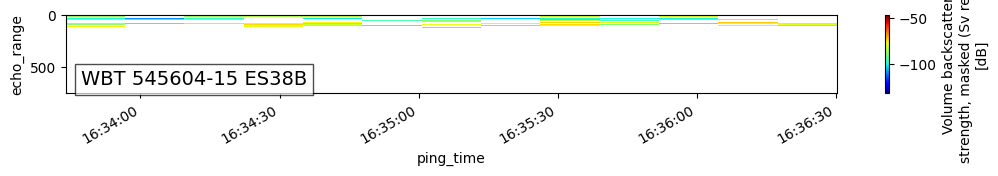

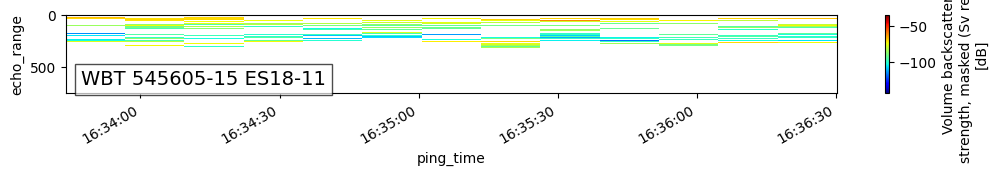

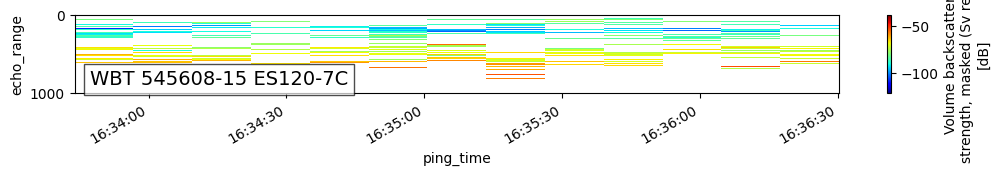

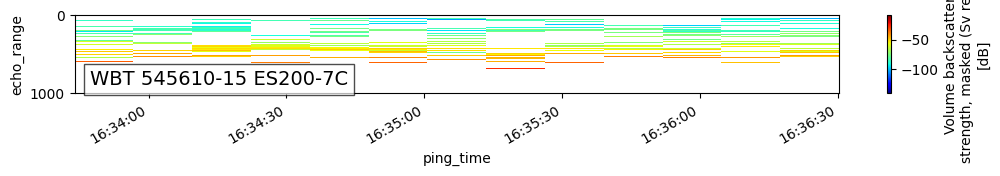

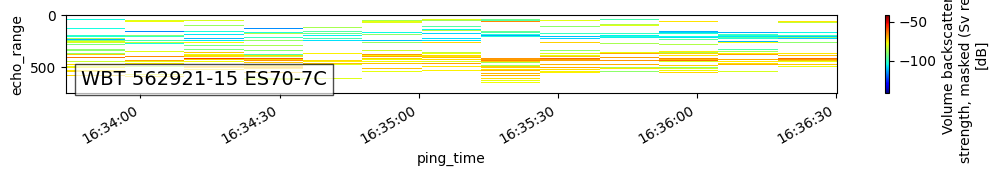

In [16]:
masked = ep.mask.apply_mask(ds_Sv_clean, krill_mask)
epviz.create_echogram(masked)